# The London Railway Network

In [1]:

from abc import ABC, abstractmethod  

class AbstractLondonRailwayMapper(ABC):
    
   
    @abstractmethod
    def __init__(self):
        pass           
        
    # data initialisation
    @abstractmethod
    def loadStationsAndLines(self):
        pass

    # returns the minimum number of stops to connect station "fromS" to station  "toS"
    # fromS : str
    # toS : str
    # numStops : int
    @abstractmethod
    def minStops(self, fromS, toS):     
        numStops = -1
        return numStops    
    
    # returns the minimum distance in miles to connect station "fromS" to station  "toS"
    # fromS : str
    # toS : str
    # minDistance : float
    @abstractmethod
    def minDistance(self, fromS, toS):
        minDistance = -1.0
        return minDistance
    
    # given an unordered list of station names, returns a new railway line 
    # (represented as a list of adjacent station names), connecting all such stations 
    # and such that the sum of the distances (in miles) between adjacent stations is minimised
    # inputList : set<str>
    # outputList : list<str>
    @abstractmethod
    def newRailwayLine(self, inputList):
        outputList = []
        return outputList

In [2]:

import math

#BINARY HEAP
class Heap():
    def __init__(self):
        self.array = []
        self.size = 0
        self.pos = {}

    def newMinHeapNode(self,v,dist):
        minHeapNode = [v, dist]
        return minHeapNode
    
    def swap(self,a,b):
        temp = self.array[a]
        self.array[a] = self.array[b]
        self.array[b] = temp
    
    def heapify(self, index):
        smallest = index
        left = 2*index + 1
        right = 2*index + 2
        if left < self. size and self.array[left][1] < self.array[smallest][1]:
            smallest = left
        if right < self.size and self.array[right][1] < self.array[smallest][1]:
            smallest = right
        if smallest != index:
            self.pos[self.array[smallest][0]] = index
            self.pos[self.array[index][0]] = smallest
            self.swap(smallest,index)
            self.heapify(smallest)
    
    def getMin(self):
        if self.isEmpty() == True:
            return
        root = self.array[0]
        last = self.array[self.size-1]
        self.array[0] = last
        self.pos[last[0]] = 0
        self.pos[root[0]] = self.size - 1
        self.size -= 1
        self.heapify(0)
        return root
    
    def isEmpty(self):
        if self.size == 0:
            return True
        else:
            return False

    def decreaseKey(self,v,dist):
        i = self.pos[v]
        self.array[i][1] = dist
        while i > 0 and self.array[i][1] < self.array[(i-1)//2][1]:
            self.pos[self.array[i][0]] = (i-1)//2
            self.pos[self.array[(i-1)//2][0]] = i
            self.swap(i, (i-1)//2)
            i = (i-1)//2
    
    def contains(self,v):
        if self.pos[v] < self.size:
            return True
        else: 
            return False

#USED FOR DFS TRAVERSAL 
class Graph:

    def __init__(self,mst):
        self.graph = mst
        self.order = []

    def DFSUtil(self, v, visited):
        visited.add(v)
        self.order.append(v)
        for neighbour in self.graph[v]:
            if neighbour not in visited:
                self.DFSUtil(neighbour, visited)
                
    def DFS(self, v):
        visited = set()
        self.DFSUtil(v, visited)
    
    def getOrder(self):
        return self.order
    
#UNION FIND FOR KRUSKAL'S ALGORITHM
class unionFind():
    def __init__(self,graph):
        self.size = {}
        self.parent = {}
        for station in graph:
            self.parent[station] = station
            self.size[station] = 1
    
    def root(self,v):
        while v != self.parent[v]:
            v = self.parent[v]
        return v
    
    def find(self,u,v):
        return self.root(u) == self.root(v)
    
    def union(self,u,v):
        rootU = self.root(u)
        rootV = self.root(v)
        if rootU == rootV:
            return
        if self.size[rootU] < self.size[rootV]:
            self.parent[rootU] = rootV
            self.size[rootV] = self.size[rootV] + self.size[rootU]
        else:
            self.parent[rootV] = rootU
            self.size[rootU] = self.size[rootU] + self.size[rootV]






In [3]:
import csv
import math
from collections import deque
import heapq
import copy

class LondonRailwayMapper(AbstractLondonRailwayMapper):
    
    def __init__(self):
        self.longLat = {}
        self.adjStations = {}          

    def loadStationsAndLines(self):
        with open("londonstations.csv") as csvFile:
            csvReader = csv.reader(csvFile, delimiter = ',')
            counter = 0
            for row in csvReader:
                if counter > 0:
                    self.longLat[row[0]] = [row[1],row[2]] #longitude, latitude
                counter = counter + 1
        #Here we have a hashmap where for each station we append all the adjacent stations
        with open("londonrailwaylines.csv") as secondFile:
            csvReader = csv.reader(secondFile,delimiter = ',')
            counter = 0
            for row in csvReader:
                if counter > 0:
                    self.adjStations.setdefault(row[1],[])#O(1)
                    if row[2] not in self.adjStations[row[1]]:#need to remove duplicates
                        self.adjStations[row[1]].append(row[2])
                    self.adjStations.setdefault(row[2],[])
                    if row[1] not in self.adjStations[row[2]]:
                        self.adjStations[row[2]].append(row[1])
                counter = counter + 1
            

    
    def minStops(self, fromS, toS):     
        numStops = -1
        dist = {}
        for station in self.longLat.keys():
            dist[station] = -1
        queue = deque()
        dist[fromS] = 0
        queue.append(fromS)
        while(queue):
            current = queue.popleft()
            for station in self.adjStations[current]:
                if(dist[station]==-1):#station hasn't been visited yet
                    queue.append(station)
                    dist[station] = dist[current] + 1
                if station == toS:#we don't need to search the entire graph
                    break
        numStops = dist[toS]
        return numStops   
    
    
    def minDistance(self, fromS, toS):
        minDistance = -1.0
        minHeap = Heap()#binary heap
        dist = {}
        parent = {}
        counter = 0
        self.heapSetUp(minHeap,dist)#the heap starts off with all the vertices in it
        dist[fromS] = 0
        parent[fromS] = -1 #the root has no parent
        minHeap.decreaseKey(fromS, dist[fromS])#update minHeap so that fromS is extracted first
        while minHeap.isEmpty() == False:
            node = minHeap.getMin()
            for station in self.adjStations[node[0]]:
                ed = self.calcDistance(node[0],station)
                if (minHeap.contains(station)) and (ed + dist[node[0]]) < dist[station]:
                    dist[station] = ed + dist[node[0]]
                    parent[station] = node[0]
                    minHeap.decreaseKey(station, dist[station])
                if node[0] == toS:
                    break

        return dist[toS]
    
    def heapSetUp(self,minHeap,dist):
        counter = 0
        for station in self.longLat.keys():
            dist[station] = math.inf
            minHeap.array.append(minHeap.newMinHeapNode(station,dist[station]))
            minHeap.pos[station] = counter
            minHeap.size = minHeap.size + 1
            counter = counter + 1

 
    def newRailwayLine(self, inputList):
        outputList = []
        # ADD YOUR CODE HERE
        parent = self.primsTree(inputList)#build the MST
        tempAdj = {}
        degree = {}
        for station in parent.keys():#create the UNDIRECTED graph
            tempAdj.setdefault(station,[])
            degree.setdefault(station,0)
        for station in parent.keys():
            if parent[station] != -1:
                self.addLink(station,parent[station],tempAdj,degree)
        branches = []
        for station in degree:
            if degree[station] > 2:#station contains branches
                branches.append(station)
        while (branches):
            node = branches.pop()
            new,old = self.findOptimalPair(node,tempAdj,degree)
            self.removeLink(old[0],old[1],tempAdj,degree)
            self.addLink(new[0],new[1],tempAdj,degree)

        for station in degree:
            if degree[station] == 1:
                start = station#start from one end 

        graph = Graph(tempAdj)
        graph.DFS(start)
        return graph.getOrder()

    def findOptimalPair(self,node,tempAdj,degree):
        bestForNode = math.inf#the weight of the smallest edge removable
        graph_copy = copy.deepcopy(tempAdj)#O(V), we use this copy for testing all possible pair swaps
        for adj in tempAdj[node]:#O(V), there are almost always three edges
            removedEd = self.removeLink(node,adj,graph_copy,degree)#removes link and returns the weight of it
            conCom = self.findConnected(graph_copy)#return the two connected components of the graph
            minIncrease = math.inf
            bestForLink = []
            leafNodePairs = self.getLeafNodes(conCom,degree)#get all the leaf nodes (degree < 1)
            for pair in leafNodePairs:
                tempIncrease = self.calcDistance(pair[0],pair[1]) - removedEd#we calculate the difference between the weights of the optimal edge and the removed edge
                if tempIncrease < minIncrease:#comparing the difference with the best for the edge removed
                    minIncrease = tempIncrease
                    bestForLink = pair
            if minIncrease < bestForNode:#comparing the difference with all edges removed
                bestForNode = minIncrease
                optimal_pair = bestForLink
                removePair = [node,adj]
            graph_copy[node].append(adj)
            graph_copy[adj].append(node)
            degree[node] = degree[node] + 1
            degree[adj] = degree[adj] + 1
        return optimal_pair, removePair
    
    def getLeafNodes(self,cc,degree):
        leafNodes1 = []
        leafNodes2 = []
        leafNodePairs = []
        for st in cc[0]:
            if degree[st] <= 1:
                leafNodes1.append(st)
        for st in cc[1]:
            if degree[st] <= 1:
                leafNodes2.append(st)
        for ln in leafNodes1:
            for ln2 in leafNodes2:
                lnPair = (ln,ln2)
                leafNodePairs.append(lnPair)
        return leafNodePairs
    
       
    def removeLink(self,node,adj,tempAdj,degree):
        tempAdj[node].remove(adj)
        tempAdj[adj].remove(node)
        degree[node] = degree[node] - 1
        degree[adj] = degree[adj] - 1 
        return self.calcDistance(node,adj)
    
    def addLink(self,u,v,tempAdj,degree):
        tempAdj[u].append(v)
        tempAdj[v].append(u)
        degree[u] = degree[u] + 1
        degree[v] = degree[v] + 1
        return
    
    #DFS ON DISCONNECTED GRAPH
    def findConnected(self,graph):
        visited = {}
        cc = []
        for v in graph:
            visited[v] = False
        for v in graph:
            if visited[v] == False:
                temp = []
                cc.append(self.DFSUtil(temp,v,visited,graph))
        return cc
    
    def DFSUtil(self,temp,v,visited,graph):
        visited[v] = True
        temp.append(v)
        for w in graph[v]:
            if visited[w] == False:
                temp = self.DFSUtil(temp,w,visited,graph)
        return temp

    def primsTree(self, inputList):
        minHeap = Heap()
        parent = {}
        dist = {}
        counter = 0
        for station in inputList:
            parent[station] = -1
            dist[station] = 1000000
            minHeap.array.append(minHeap.newMinHeapNode(station,dist[station]))#we can use the same binary heap for Prim's algorithm
            minHeap.pos[station] = counter
            minHeap.size = minHeap.size + 1
            counter = counter + 1
        dist[inputList[0]] = 0
        minHeap.decreaseKey(inputList[0], dist[inputList[0]])
        while minHeap.isEmpty()==False:
            node = minHeap.getMin()
            for station in inputList:
                ed = self.calcDistance(node[0], station)
                if minHeap.contains(station) and ed < dist[station]:
                    dist[station] = ed 
                    parent[station] = node[0]
                    minHeap.decreaseKey(station, dist[station])
        return parent

    def calcTrackLength(self, inputList):#used to calculate the length of a given track
        dist = 0
        for i in range(0,len(inputList)-1):
            dist = dist + self.calcDistance(inputList[i],inputList[i+1])
        return dist
    
    #CALCULATING EUCLIDEAN DISTANCE
    def convertToCartesian(self,point):
        radius = 6371
        x = 6371*math.cos(float(point[0])*(math.pi/180))*math.cos(float(point[1])*(math.pi/180))
        y = 6371*math.cos(float(point[0])*(math.pi/180))*math.sin(float(point[1])*(math.pi/180))
        z = 6371*math.sin(float(point[0])*(math.pi/180))
        return [x,y,z]
    
    def calcDistance(self,fromS,toS):
        point1 = self.convertToCartesian(self.longLat[fromS])
        point2 = self.convertToCartesian(self.longLat[toS])
        dist = ((float(point2[0])-float(point1[0]))**2+(float(point2[1])-float(point1[1]))**2+(float(point2[2])-float(point1[2]))**2)**0.5
        return dist * 0.621371



Use the cell below for all python code needed to test the `LondonRailwayMapper` class above.

In [4]:
import timeit
from matplotlib import pyplot as plt
import random
import math

# ADD YOUR TEST CODE HERE (Code for testing with random graphs at the bottom)
def getRandomStations(longLat,n):
    longLatList = list(longLat.items())
    rand_list = []
    i = 0
    while i < n:
        random_entry = random.choice(longLatList)
        if random_entry[0] not in rand_list:
            rand_list.append(random_entry[0])
            i = i + 1
    return rand_list

def testLoadStations():
    test = LondonRailwayMapper()
    total = 0
    for i in range(0,10):
        t1 = timeit.default_timer()
        test.loadStationsAndLines()
        t2 = timeit.default_timer()
        total = total + (t2 - t1)
    return total/10


def testMinStops():
    test = LondonRailwayMapper()
    test.loadStationsAndLines()
    statList = list(test.longLat.items())
    i = 0
    time = 0
    while i < 100:
        rand_entry1 = random.choice(statList)[0]
        rand_entry2 = random.choice(statList)[0]
        t1 = timeit.default_timer()
        test.minStops(rand_entry1,rand_entry2)
        t2 = timeit.default_timer()
        time = time + (t2-t1)
        i = i + 1
    print(time/100)

def testMinDistance():
    test = LondonRailwayMapper()
    test.loadStationsAndLines()
    statList = list(test.longLat.items())
    i = 0
    time = 0
    while i < 100:
        rand_entry1 = random.choice(statList)[0]
        rand_entry2 = random.choice(statList)[0]
        t1 = timeit.default_timer()
        test.minDistance(rand_entry1,rand_entry2)
        t2 = timeit.default_timer()
        time = time + (t2-t1)
        i = i + 1
    print(time/100)



def testTSP():
    test = LondonRailwayMapper()
    test.loadStationsAndLines()
    sizes = [5,10,20,50,100,200,500]
    results = []
    for n in sizes:
        totalTime = 0
        for i in range(0,3):
            stations = getRandomStations(test.longLat,n)
            t1 = timeit.default_timer()
            test.newRailwayLine(stations)
            t2 = timeit.default_timer()
            totalTime = totalTime + (t2-t1)
        results.append(totalTime/3)
    print(results)


#testTSP
#testMinDistance
#testMinStops
#testLoadStations






Testing:

In [11]:


import timeit

testMapper = LondonRailwayMapper()


starttime = timeit.default_timer()
testMapper.loadStationsAndLines()
endtime = timeit.default_timer()
print("\nExecution time to load:", round(endtime-starttime,3))

fromList = ["Baker Street", "Epping", "Canonbury", "Vauxhall"]
toList = ["North Wembley", "Belsize Park", "Balham", "Leytonstone"]

for i in range(len(fromList)):
    starttime = timeit.default_timer()
    stops = testMapper.minStops(fromList[i], toList[i])
    endtime = timeit.default_timer()
    print("\nExecution time minStops:", round(endtime-starttime,3))

    starttime = timeit.default_timer()
    dist = testMapper.minStops(fromList[i], toList[i])
    endtime = timeit.default_timer()
    print("Execution time minDistance:", round(endtime-starttime,3))

    print("From", fromList[i], "to", toList[i], "in", stops, "stops and", dist, "miles")  
    

stationsList = ["Queens Park", "Chigwell", "Moorgate", "Swiss Cottage", "Liverpool Street", "Highgate"]

starttime = timeit.default_timer()
newLine = testMapper.newRailwayLine(stationsList)
endtime = timeit.default_timer()

print("\n\nStation list", stationsList)
print("New station line", newLine)
print("Total track length from", newLine[0], "to", newLine[len(newLine)-1], ":", testMapper.minDistance(newLine[0], newLine[len(newLine)-1]), "miles")
print("Execution time newLine:", round(endtime-starttime,3))


stationsList = ["Abbey Road", "Barbican", "Bethnal Green", "Cambridge Heath", "Covent Garden", "Dollis Hill", "East Finchley", "Finchley Road and Frognal", "Great Portland Street", "Hackney Wick", "Isleworth", "Kentish Town West", "Leyton", "Marble Arch", "North Wembley", "Old Street", "Pimlico", "Queens Park", "Richmond", "Shepherds Bush", "Tottenham Hale", "Uxbridge", "Vauxhall", "Wapping"]

starttime = timeit.default_timer()
newLine = testMapper.newRailwayLine(stationsList)
endtime = timeit.default_timer()

print("\n\nStation list", stationsList)
print("New station line", newLine)
print("Total track length from", newLine[0], "to", newLine[len(newLine)-1], ":", testMapper.minDistance(newLine[0], newLine[len(newLine)-1]), "miles")
print("Execution time newLine:", round(endtime-starttime,3))


Execution time to load: 0.008

Execution time minStops: 0.002
Execution time minDistance: 0.001
From Baker Street to North Wembley in 6 stops and 6 miles

Execution time minStops: 0.001
Execution time minDistance: 0.001
From Epping to Belsize Park in 17 stops and 17 miles

Execution time minStops: 0.001
Execution time minDistance: 0.001
From Canonbury to Balham in 10 stops and 10 miles

Execution time minStops: 0.001
Execution time minDistance: 0.001
From Vauxhall to Leytonstone in 6 stops and 6 miles


Station list ['Queens Park', 'Chigwell', 'Moorgate', 'Swiss Cottage', 'Liverpool Street', 'Highgate']
New station line ['Chigwell', 'Liverpool Street', 'Moorgate', 'Highgate', 'Swiss Cottage', 'Queens Park']
Total track length from Chigwell to Queens Park : 18.710011177750367 miles
Execution time newLine: 0.002


Station list ['Abbey Road', 'Barbican', 'Bethnal Green', 'Cambridge Heath', 'Covent Garden', 'Dollis Hill', 'East Finchley', 'Finchley Road and Frognal', 'Great Portland Stree

In [6]:
#EVALUATION OF ALGORITHMS

import csv
import math
import copy

#THE EXACT ALGORITHM
class bruteForce():
    def __init__(self, longLat):
        self.longLat = longLat
        self.sol = []
        self.minD = 1000
    
    def bruteForce(self,stations):
        stations_copy = stations.copy()
        self.bruteUtil([],stations_copy)
        return self.sol
    
    def bruteUtil(self, route, notInRoute):
        if notInRoute:#if it has stuff in it
            for station in notInRoute:
                justRemoved = notInRoute.pop(0)
                newRoute  = route.copy()
                newRoute.append(justRemoved)
                self.bruteUtil(newRoute,notInRoute)
                notInRoute.append(justRemoved)
        else:
            
            dist = 0
            for i in range(0,len(route)-1):
                dist = dist + self.calcDistance(route[i],route[i+1])
            if dist < self.minD:
                self.minD = dist
                self.sol = route

    def convertToCartesian(self,point):
        radius = 6371
        x = 6371*math.cos(float(point[0])*(math.pi/180))*math.cos(float(point[1])*(math.pi/180))
        y = 6371*math.cos(float(point[0])*(math.pi/180))*math.sin(float(point[1])*(math.pi/180))
        z = 6371*math.sin(float(point[0])*(math.pi/180))
        return [x,y,z]
    
    def calcDistance(self,fromS,toS):
        point1 = self.convertToCartesian(self.longLat[fromS])
        point2 = self.convertToCartesian(self.longLat[toS])
        dist = ((float(point2[0])-float(point1[0]))**2+(float(point2[1])-float(point1[1]))**2+(float(point2[2])-float(point1[2]))**2)**0.5
        return dist * 0.621371


#COPY OF LONDON RAILWAY MAPPER WITH OTHER ALGORITHMS               
class TestMapper():
    
    def __init__(self):
        # ADD YOUR CODE HERE
        self.longLat = {}
        self.adjStations = {}          

    
        
    def loadStationsAndLines(self):
        # ADD YOUR CODE HERE
        with open("londonstations.csv") as csvFile:
            csvReader = csv.reader(csvFile, delimiter = ',')
            counter = 0
            for row in csvReader:
                if counter > 0:
                    self.longLat[row[0]] = [row[1],row[2]]
                counter = counter + 1
        
        with open("londonrailwaylines.csv") as secondFile:
            csvReader = csv.reader(secondFile,delimiter = ',')
            counter = 0
            for row in csvReader:
                if counter > 0:
                    self.adjStations.setdefault(row[1],[])
                    if row[2] not in self.adjStations[row[1]]:#no duplicates
                        self.adjStations[row[1]].append(row[2])
                    self.adjStations.setdefault(row[2],[])
                    if row[1] not in self.adjStations[row[2]]:
                        self.adjStations[row[2]].append(row[1])
                counter = counter + 1
    
    
    
    #GREEDY BRANCH ELIMINATION METHOD
    def greedyTSP(self,inputList):
        outputList = []
        # ADD YOUR CODE HERE
        parent = self.primsTree(inputList)
        tempAdj = {}
        degree = {}
        self.graph_setup(tempAdj,degree,parent)
        branches = []
        for station in degree:
            if degree[station] > 2: 
                branches.append(station)
        while (branches):
            node = branches.pop()
            longestBranch = self.findLongestBranch(node,tempAdj)#find the longest branch of the node
            self.removeLink(longestBranch,node,tempAdj,degree)#remove it
            twoComps = self.findConnected(tempAdj)#find connected components
            shortestEdge = self.findShortestLink(twoComps,node,longestBranch,degree)#find shortest edge connecting them
            self.addLink(shortestEdge[0],shortestEdge[1],tempAdj,degree)#add the edge
        for station in degree:
            if degree[station] == 1:
                start = station#start from one end 
        graph = Graph(tempAdj)
        graph.DFS(start)#O(V+E)
        return graph.getOrder()
    
    def graph_setup(self,tempAdj,degree,parent):
        for station in parent.keys():
            tempAdj.setdefault(station,[])
            degree.setdefault(station,0)
        for station in parent.keys():
            if parent[station] != -1:
                tempAdj[station].append(parent[station])
                tempAdj[parent[station]].append(station)
                degree[station] = degree[station] + 1
                degree[parent[station]] = degree[parent[station]] + 1
        return tempAdj,degree

    
    
    def removeLink(self,node,adj,tempAdj,degree):
        tempAdj[node].remove(adj)#O(V)
        tempAdj[adj].remove(node)#O(V)
        degree[node] = degree[node] - 1
        degree[adj] = degree[adj] - 1 
        return self.calcDistance(node,adj)
    
    def addLink(self,u,v,tempAdj,degree):
        tempAdj[u].append(v)
        tempAdj[v].append(u)
        degree[u] = degree[u] + 1
        degree[v] = degree[v] + 1
        return
        
    
    def findShortestLink(self,twoComps,st1,st2,degree):
        minD = math.inf
        for x in twoComps[0]:
            if degree[x] <= 1:
                for y in twoComps[1]:
                    if degree[y] <= 1:
                        if not((x == st1 and y == st2) or ( x==st2 and y == st1)):
                            ed = self.calcDistance(x,y)
                            if ed < minD:
                                minD = ed
                                shortestEdge = [x,y]
        return shortestEdge


    
    def findConnected(self,graph):
        visited = {}
        cc = []
        for v in graph:
            visited[v] = False
        for v in graph:
            if visited[v] == False:
                temp = []
                cc.append(self.DFSUtil(temp,v,visited,graph))
        return cc
    
    def DFSUtil(self,temp,v,visited,graph):
        visited[v] = True
        temp.append(v)
        for w in graph[v]:
            if visited[w] == False:
                temp = self.DFSUtil(temp,w,visited,graph)
        return temp

        
    def findLongestBranch(self,node,tempAdj):
        maxD = 0
        branch = None
        for station in tempAdj[node]:
            ed = self.calcDistance(node,station)
            if ed > maxD:
                maxD = ed
                branch = station
        return branch


    def primsTree(self, inputList):
        minHeap = Heap()
        parent = {}
        dist = {}
        counter = 0
        for station in inputList:
            parent[station] = -1
            dist[station] = 1000000
            minHeap.array.append(minHeap.newMinHeapNode(station,dist[station]))
            minHeap.pos[station] = counter
            minHeap.size = minHeap.size + 1
            counter = counter + 1
        dist[inputList[0]] = 0
        minHeap.decreaseKey(inputList[0], dist[inputList[0]])
        while minHeap.isEmpty()==False:
            node = minHeap.getMin()
            for station in inputList:
                ed = self.calcDistance(node[0], station)
                if minHeap.contains(station) and ed < dist[station] and ed != 0 :
                    dist[station] = ed 
                    parent[station] = node[0]
                    minHeap.decreaseKey(station, dist[station])
        return parent

    
    def kruskalTree(self,inputList):
        totalWeight = 0
        connectedG = {}
        dist = {}
        for v in inputList:
            for w in inputList:
                if v!=w and (v,w) not in dist and (w,v) not in dist:#create graph
                    connectedG.setdefault(v,[])
                    connectedG.setdefault(w,[])
                    connectedG[v].append(w)
                    connectedG[w].append(v)
                    dist[(v,w)] = self.calcDistance(v,w)
        distList = list(dist.items())
        self.mergeSort(distList)
        uf = unionFind(connectedG)#we use the union find to detect whether u,v are in the same component
        i = 0
        result = {}
        while i < len(distList)-1:
            u = distList[i][0][0]
            v = distList[i][0][1]
            w = distList[i][1]
            if uf.find(u,v) == False:
                result.setdefault(u,[])
                result.setdefault(v,[])
                result[u].append(v)
                result[v].append(u)
                totalWeight = totalWeight + w
                uf.union(u,v)
            i = i + 1
        return result,totalWeight

    #Merge sort for Kruskal's algorithm
    def mergeSort(self,array):
        if len(array) > 1:
            mid = len(array)//2
            left = array[:mid]
            right = array[mid:]
            self.mergeSort(left)
            self.mergeSort(right)
            i = j = k = 0
            while i < len(left) and j < len(right):
                if left[i][1] < right[j][1]:
                    array[k] = left[i]
                    i += 1
                else:
                    array[k] = right[j]
                    j += 1
                k += 1
            while i < len(left):
                array[k] = left[i]
                i += 1
                k += 1
            while j < len(right):
                array[k] = right[j]
                j += 1
                k += 1

    
    def calcTrackLength(self, inputList):
        dist = 0
        for i in range(0,len(inputList)-1):
            dist = dist + self.calcDistance(inputList[i],inputList[i+1])
        return dist
    
    def convertToCartesian(self,point):
        radius = 6371
        x = 6371*math.cos(float(point[0])*(math.pi/180))*math.cos(float(point[1])*(math.pi/180))
        y = 6371*math.cos(float(point[0])*(math.pi/180))*math.sin(float(point[1])*(math.pi/180))
        z = 6371*math.sin(float(point[0])*(math.pi/180))
        return [x,y,z]
    
    def calcDistance(self,fromS,toS):
        point1 = self.convertToCartesian(self.longLat[fromS])
        point2 = self.convertToCartesian(self.longLat[toS])
        dist = ((float(point2[0])-float(point1[0]))**2+(float(point2[1])-float(point1[1]))**2+(float(point2[2])-float(point1[2]))**2)**0.5
        return dist * 0.621371




In [7]:
#TESTING FOR TSP
import random

def testExact(testList,longLat):
    exactAlg = bruteForce(longLat)
    line = exactAlg.bruteForce(testList)
    return line

def testAllPairs(test,testList):
    line = test.newRailwayLine(testList)
    return line

def testGreedy(test,testList):
    line = test.greedyTSP(testList)
    return line

def getRandomStations(longLat,n):
    longLatList = list(longLat.items())
    rand_list = []
    i = 0
    while i < n:
        random_entry = random.choice(longLatList)
        if random_entry[0] not in rand_list:#no duplicates
            rand_list.append(random_entry[0])
            i = i + 1
    return rand_list

def compareLines(line1, line2):
    line2_copy = line2.copy()
    line2_copy.reverse()
    for i in range(0,len(line1)):
        if line1[i] != line2[i] and line1[i] != line2_copy[i]:
            print(line1,"Correct")
            print(line2)
            return False
    return True

def lowerBound(stations,test):#the MST can serve as lower bound despite not actually being a solution to the problem
    parent,weight = test.kruskalTree(stations)
    return weight

def mstApprox(stations,test):#This is the 2-approximation MST algorithm. We create the mst using Kruskal's and then perform DFS, returning the order the vertices were visited in
    graph,n = test.kruskalTree(stations)
    for station in graph:
        if len(graph[station]) == 1:
            start = station
    mst = Graph(graph)
    mst.DFS(start)
    return mst.getOrder()
           
def railway_accuracy():#computes margin of error at the moment
    test = LondonRailwayMapper()
    test.loadStationsAndLines()
    secondTest = TestMapper()
    secondTest.loadStationsAndLines()
    n_inputs = [5,7,9,10]#may take a while!
    greedyResults = []
    allPairsResults = []
    mstAppResults = []
    for n in n_inputs:
        apT = gT = mstT = 0
        for i in range(0,1):
            testLine = getRandomStations(test.longLat,n)
            exactLine = testExact(testLine,test.longLat)
            allPairsLine = testAllPairs(test,testLine)
            greedyLine = testGreedy(secondTest,testLine)
            lb = lowerBound(testLine,secondTest)
            mstApp = mstApprox(testLine,secondTest)
            exactLen = test.calcTrackLength(exactLine)
            allPairsLen = test.calcTrackLength(allPairsLine)
            greedyLen = test.calcTrackLength(greedyLine)
            mstAppLen = test.calcTrackLength(mstApp)
        result1 = allPairsLen - exactLen
        result2 = greedyLen - exactLen
        result3 = mstAppLen - exactLen
        allPairsResults.append((result1/exactLen)*100)
        greedyResults.append((result2/exactLen)*100)
        mstAppResults.append((result3/exactLen)*100)
    print(greedyResults)
    print(allPairsResults)
    print(mstAppResults)

           
def railway_track_lengths():#computes track lengths of 2-approx,greedy and all-pair methods
    test = LondonRailwayMapper()
    test.loadStationsAndLines()
    secondTest = TestMapper()
    secondTest.loadStationsAndLines()
    n_inputs = [10,20,50,100,200,500]
    greedyResults = []
    allPairsResults = []
    mstAppResults = []
    for n in n_inputs:
        apT = gT = mstT = 0
        testLine = getRandomStations(test.longLat,n)
        for i in range(0,3):
            allPairsLine = testAllPairs(test,testLine)
            greedyLine = testGreedy(secondTest,testLine)
            mstApp = mstApprox(testLine,secondTest)
            allPairsLen = test.calcTrackLength(allPairsLine)
            greedyLen = test.calcTrackLength(greedyLine)
            mstAppLen = test.calcTrackLength(mstApp)
            apT = apT + allPairsLen
            gT = gT + greedyLen
            mstT = mstT + mstAppLen
        allPairsResults.append(apT/3)
        greedyResults.append(gT/3)
        mstAppResults.append(mstT/3)
    print(greedyResults)
    print(allPairsResults)
    print(mstAppResults)

def railway_time():#records time for each 
    test1 = LondonRailwayMapper()
    test2 = TestMapper()
    test1.loadStationsAndLines()
    test2.loadStationsAndLines()
    mstApp = []
    greedy = []
    allPair = []
    n_inputs = [5,10,20,50,100,200,500]
    for n in n_inputs:
        total1 = total2 = total3 = 0
        stats = getRandomStations(test.longLat,n)
        for i in range(0,3):
            t1 = timeit.default_timer()
            mstAppLine = mstApprox(stats,test2)
            t2 = timeit.default_timer()
            greedyLine = test2.greedyTSP(stats)
            t3 = timeit.default_timer()
            allPairLine = test1.newRailwayLine(stats)
            t4 = timeit.default_timer()
            total1 = total1 + (t2-t1)
            total2 = total2 + (t3-t2)
            total3 = total3 + (t4-t3)
        mstApp.append(total1/3)
        greedy.append(total2/3)
        allPair.append(total3/3)
    print(mstApp)
    print(greedy)
    print(allPair)


def compareTrees():#compare time complexity of Kruskal's and Prim's
    test = TestMapper()
    test.loadStationsAndLines()
    n_inputs = [10,20,50,100,200,500]
    kruskalResults = []
    primResults = []
    for n in n_inputs:
        stations = getRandomStations(test.longLat,n)
        k = 0
        p = 0
        for i in range(0,3):
            t1 = timeit.default_timer()
            test.kruskalTree(stations)
            t2 = timeit.default_timer()
            test.primsTree(stations)
            t3 = timeit.default_timer()  
            k = k + (t2-t1)
            p = p + (t3-t2)
        kruskalResults.append(k/3)
        primResults.append(p/3)
    print(kruskalResults)
    print(primResults)




#railway_time()
#compareTrees()
#railway_track_lengths()
#railway_accuracy()



53.78463885790438 Exact
53.78463885790439 Greedy
53.78463885790439 All pairs
55.71250128925034 MST approx


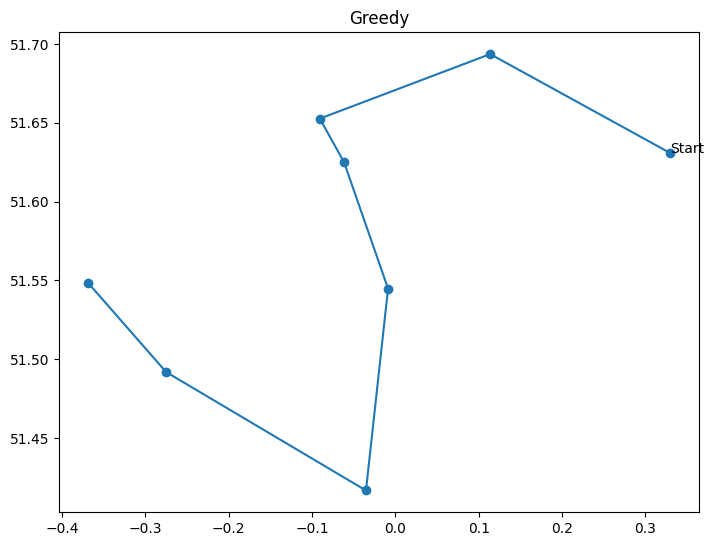

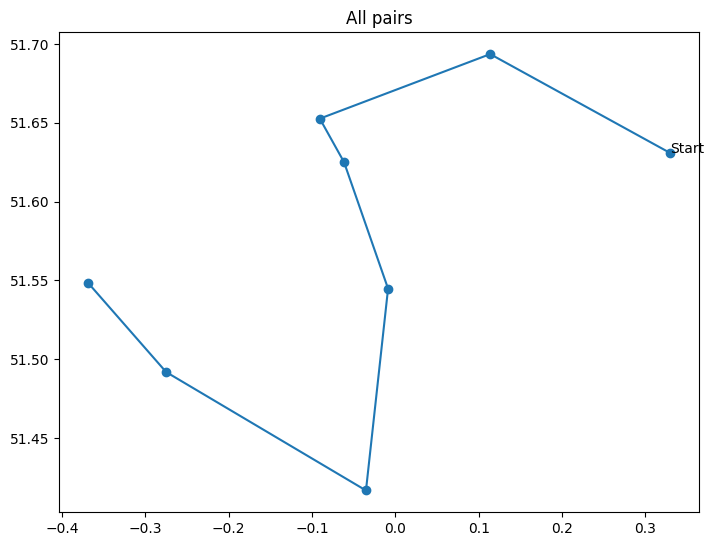

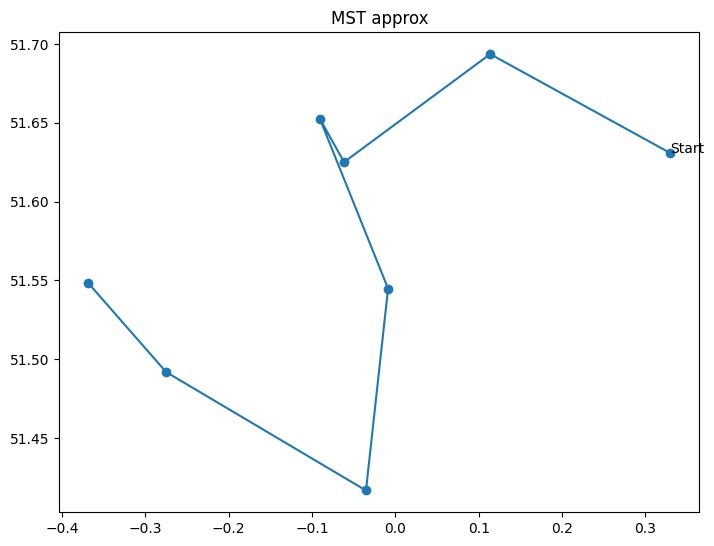

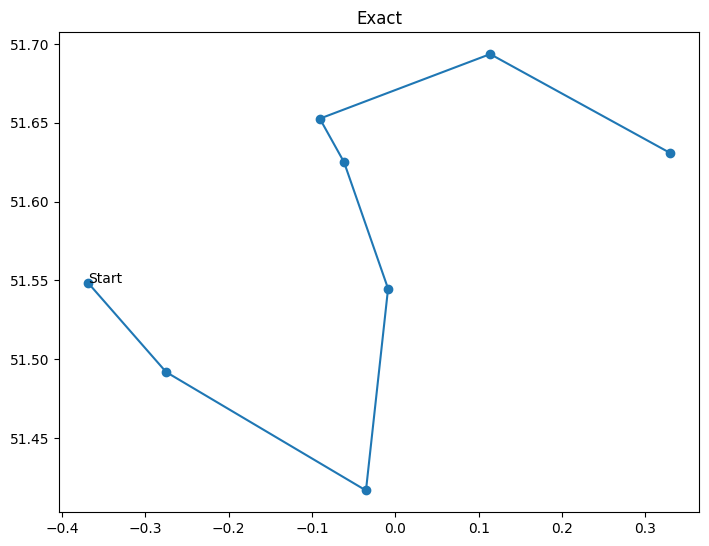

In [8]:
#GRAPHING CELL

import numpy as np
import matplotlib.pyplot as plt
import timeit

def plotGraph(solution,title):#visualise the new line
    xs = []
    ys = []
    for station in solution:
        x = (float(test.longLat[station][1]))
        y = (float(test.longLat[station][0])) 
        xs.append(x)
        ys.append(y)
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.scatter(xs,ys)
    ax.plot(xs,ys)
    plt.annotate("Start",(xs[0],ys[0]))
    plt.title(title)
    plt.show()




main = LondonRailwayMapper()
test = TestMapper()
test.loadStationsAndLines()
main.loadStationsAndLines()
random_stations = getRandomStations(test.longLat,8)
line1 = test.greedyTSP(random_stations)
line2 = main.newRailwayLine(random_stations)
line3  = mstApprox(random_stations,test)
exact = bruteForce(test.longLat)
trueLine = exact.bruteForce(random_stations)
print(test.calcTrackLength(trueLine),"Exact")
print(test.calcTrackLength(line1),"Greedy")
print(test.calcTrackLength(line2),"All pairs")
print(test.calcTrackLength(line3),"MST approx")
plotGraph(line1,"Greedy")
plotGraph(line2,"All pairs")
plotGraph(line3,"MST approx")
plotGraph(trueLine,"Exact")








In [9]:
import csv
import math
import copy
#TESTING MIN STOPS AND MIN DISTANCE USING RANDOMLY GENERATED GRAPHS



def modifiedMinStops(graph,fromS,toS):
    dist = {}
    parent = {}
    for station in graph:
        parent[station] = -1
        dist[station] = -1
        queue = deque()
    dist[fromS] = 0
    queue.append(fromS)
    while(queue):
        current = queue.popleft()
        for station in graph[current]:
            if(dist[station]==-1):#station hasn't been visited yet
                queue.append(station)
                dist[station] = dist[current] + 1
                parent[station] = current
    numStops = dist[toS]
    return numStops   

def modifiedMinDist(graph, fromS, toS):#graph parameter as we're not using the stations file
    minHeap = Heap()
    dist = {}
    parent = {}
    counter = 0
    for station in graph:
        dist[station] = math.inf
        minHeap.array.append(minHeap.newMinHeapNode(station,dist[station]))
        minHeap.pos[station] = counter
        minHeap.size = minHeap.size + 1
        counter = counter + 1
    dist[fromS] = 0
    parent[fromS] = -1
    minHeap.decreaseKey(fromS, dist[fromS])
    while minHeap.isEmpty() == False:
        node = minHeap.getMin()
        for station in graph[node[0]]:
            if (minHeap.contains(station)) and (weight(node[0],station) + dist[node[0]]) < dist[station]:
                dist[station] = weight(node[0],station) + dist[node[0]]
                parent[station] = node[0]
                minHeap.decreaseKey(station, dist[station])
    return dist[toS]

def weight(u,v):
    return abs(u-v)

def graphMaker1(n,e):#for creating graphs to be tested with minDistance
    graph = {}
    vertices = []
    for j in range(0,n):
        vertices.append(j)
        graph.setdefault(j,[])
    i = 0
    while i < e:
        u = random.randint(0,n-1)
        v = random.randint(0,n-1)
        if u!=v and u not in graph[v] and v not in graph[u] and len(graph[v]) < e/10 and len(graph[u]) < e/10:#Spread out edges in the graph
            graph[u].append(v)
            graph[v].append(u)
            i = i + 1
    return graph

def graphMaker2(n,e):#for creating graphs to be tested with minStops
    graph = {}
    vertices = []
    for i in range(0,n):
        vertices.append(i)
        graph.setdefault(i,[])
    i = 0
    while i < e:
        u = random.randint(0,n-1)#pick two random points
        v = random.randint(0,n-1)
        if u!=v and u not in graph[v] and v not in graph[u]:#check if they haven't already been added
            graph[u].append(v)
            graph[v].append(u)
            i = i + 1
    return graph


def testMinStopsV():
    v = [10,50,100,200,500,1000]
    e = 25
    results = []
    for i in v:
        totalTime = 0
        graph = graphMaker2(i,e)
        for j in range(0,3):
            t1 = timeit.default_timer()
            modifiedMinStops(graph,random.randint(0,i-1),random.randint(0,i-1))
            t2 = timeit.default_timer()
            totalTime = totalTime + (t2-t1)
        results.append(totalTime/3)
    print(results)

def testMinDistanceV():
    #v = [10,50,100,200,500,1000]
    #e = 25
    e = [100,200,400,800,1600,3200]
    v = 100
    results = []
    for i in e:
        totalTime = 0
        for j in range(0,3):
            graph = graphMaker1(v,i)
            t1 = timeit.default_timer()
            modifiedMinDist(graph,random.randint(0,v-1),random.randint(0,v-1))
            t2 = timeit.default_timer()
            totalTime = totalTime + (t2-t1)
        results.append(totalTime/3)
    print(results)


